# Задача 5. Обучение без учителя

* **Дедлайн**: 14.04.2023, 23:59
* **Основной полный балл**: 5
* **Максимум баллов**: 10

## Задача

- [x] Найти данные с количеством признаков хотя бы 50, на которых можно решить задачу кластеризации.
- [x] Выполнить разведочный анализ (**EDA**). При необходимости выполнить полезные преобразования данных.
- [x] Самостоятельно реализуйте один из алгоритмов кластеризации, например **K-means**.
- [x] Обучите модели кластеризации, используя свою реализацию, а также хотя бы две реализации из **sklearn** (**KMeans**, **Affinity Propogation**, **DBSCAN** и тд).
- [x] При обучении использовать **подбор гиперпараметров**.
- [x] Сравнить качество моделей: замерить скорость обучения, вычислить различные метрики качества.
- [x] * (**+3 балла**) Также снизить размерность данных с помощью метода главных компонент **PCA** и и понять качество дальнейшей кластеризации всеми использованными реализациями при различном количестве главных компонент.
- [x] * (**+2 балла**) Визуализировать данные снижением размерности до 2 или 3 с помощью **PCA** и **t-SNE**. В случае проблем с производительностью **t-SNE**, можно сначала до какой то степени снизить размерность с помощью **PCA**, а затем запустить **t-SNE**.

## Подготовка

Так как OpenBLAS "по кайфу" работать только пока количество потоков не превысило 50, устанавливаем ограничения, без которых алгоритмы не заработают на 16-и ядерном процессоре.

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

os.environ["OMP_NUM_THREADS"] = "24"
os.environ["OPENBLAS_NUM_THREADS"] = "24"

## Датасет

Будем использовать MNIST (Modified National Institute of Standards and Technology) - это, вероятно, самый распространенный датасет для задачи кластеризации. Он состоит из 70 000 изображений рукописных цифр от 0 до 9 размером 28 на 28 пикселей. Данные можно загрузить с сайта Kaggle: [https://www.kaggle.com/competitions/digit-recognizer/data](https://www.kaggle.com/competitions/digit-recognizer/data).

In [2]:
df = pd.read_csv("datasets/train.csv", dtype=np.uint8)
X = df.drop(columns=["label"])
y = df["label"]
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Всего существует 10 различных объектов -- числа от 0 до 9. Заметим, что кластеры должны быть примерно равномерны, так как количество объектов для каждого числа почти одинаково.

In [3]:
y.value_counts().sort_index()

0    4132
1    4684
2    4177
3    4351
4    4072
5    3795
6    4137
7    4401
8    4063
9    4188
Name: label, dtype: int64

## EDA

## Визуализация с помощью PCA и t-SNE
Визуализируем данные при помощи понижения размерности до двух

In [4]:
from sklearn.decomposition import PCA

In [5]:
%%time

pca = PCA()
pca_result = pca.fit_transform(X)

CPU times: total: 15.7 s
Wall time: 1.49 s


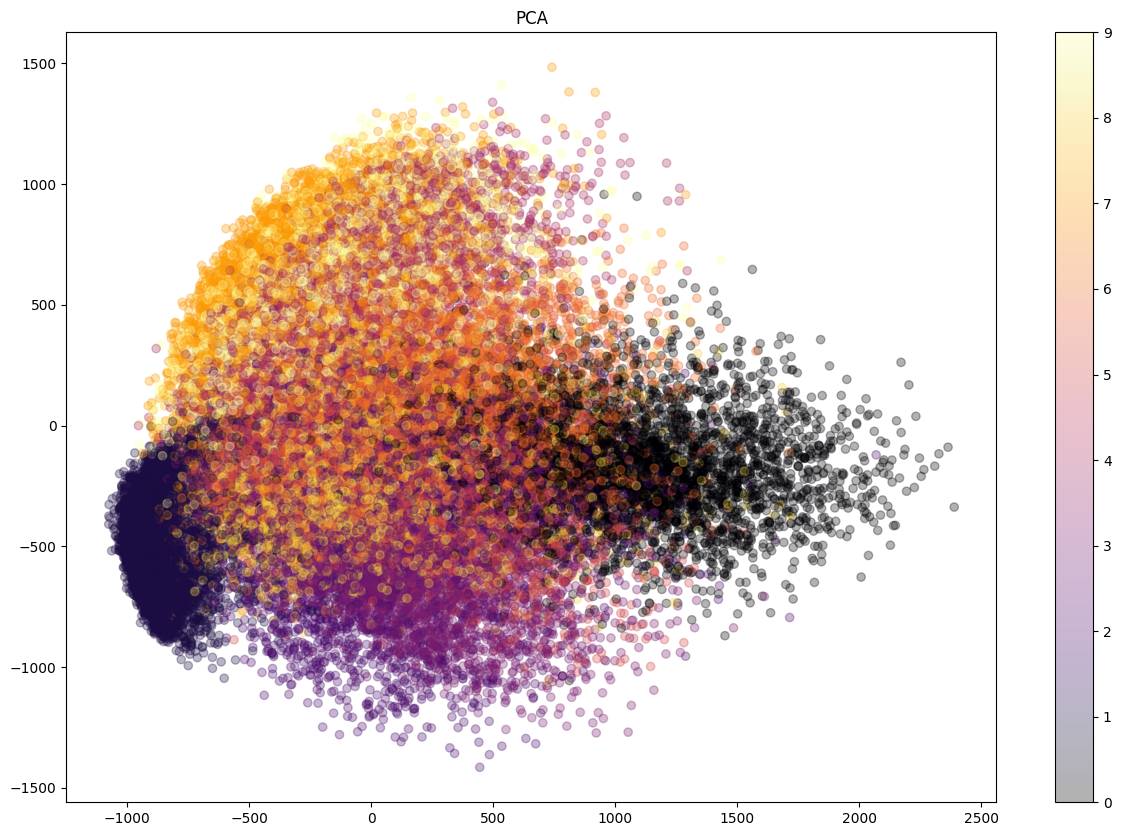

In [6]:
plt.figure(figsize=(15, 10))
plt.scatter(pca_result[:,0], pca_result[:,1], c=y, cmap='inferno', alpha=0.3)
plt.colorbar()
plt.title('PCA');

Заметим разделение на кластера, однако объекты разных групп сильно перемешаны.

In [7]:
%%time
from sklearn.manifold import TSNE

tsne = TSNE(random_state=0)
tsne_result = tsne.fit_transform(X)

CPU times: total: 21min 59s
Wall time: 57.6 s


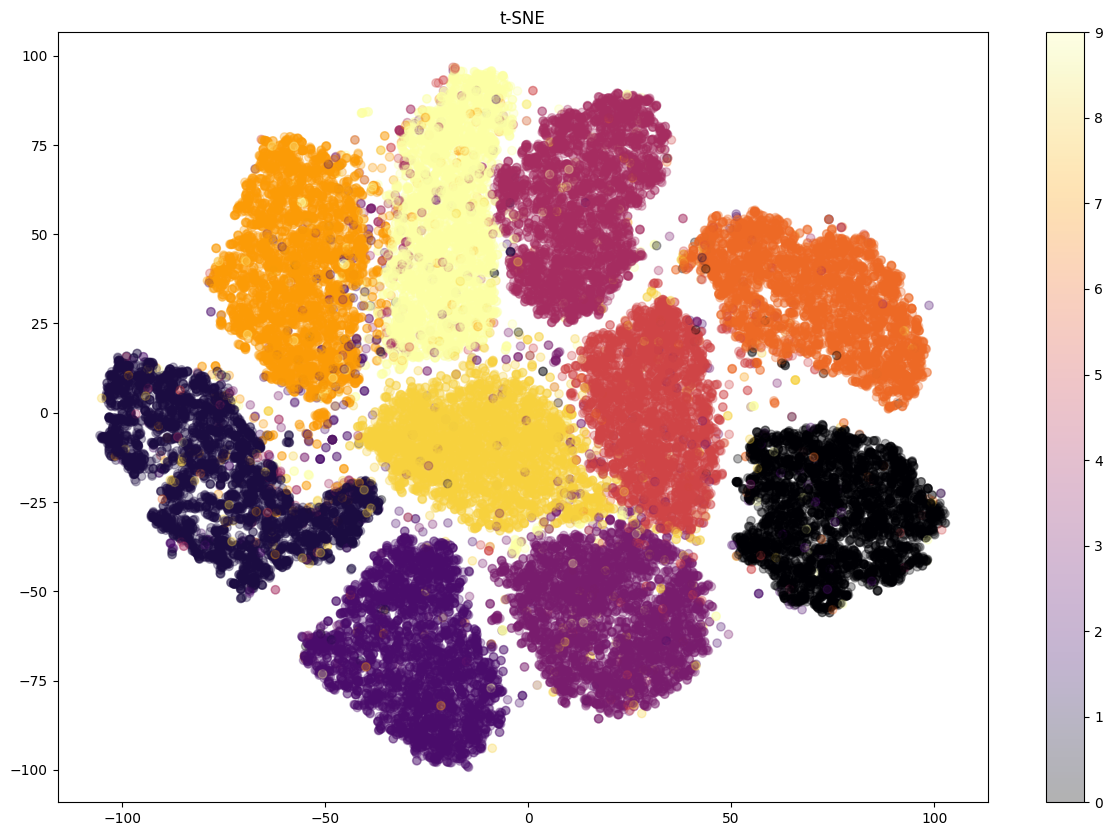

In [8]:
plt.figure(figsize=(15, 10))
plt.scatter(tsne_result[:,0], tsne_result[:,1], c=y, cmap='inferno', alpha=0.3)
plt.colorbar()
plt.title('t-SNE');

С t-SNE ситуация существенно лучше. Несмотря на то, что кластеры образуют явные группы, объектов между группами остаётся немало. Нельзя не заметить и скорость работы t-SNE, которая значительно превышает PCA.

Далее при обучении будем снижать размерность датасета при помощи PCA.

Попробуем изобразить данные посредством понижения размерности. Выясним, можем ли понизить размерность без потерь.

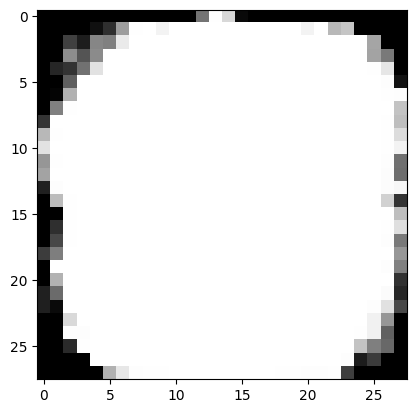

In [7]:
plt.imshow(X.max().values.reshape((28, 28)), cmap="gray")

Предположим, что размерность можно снизить, как минимум избавившись от неиспользуемых пикселей.

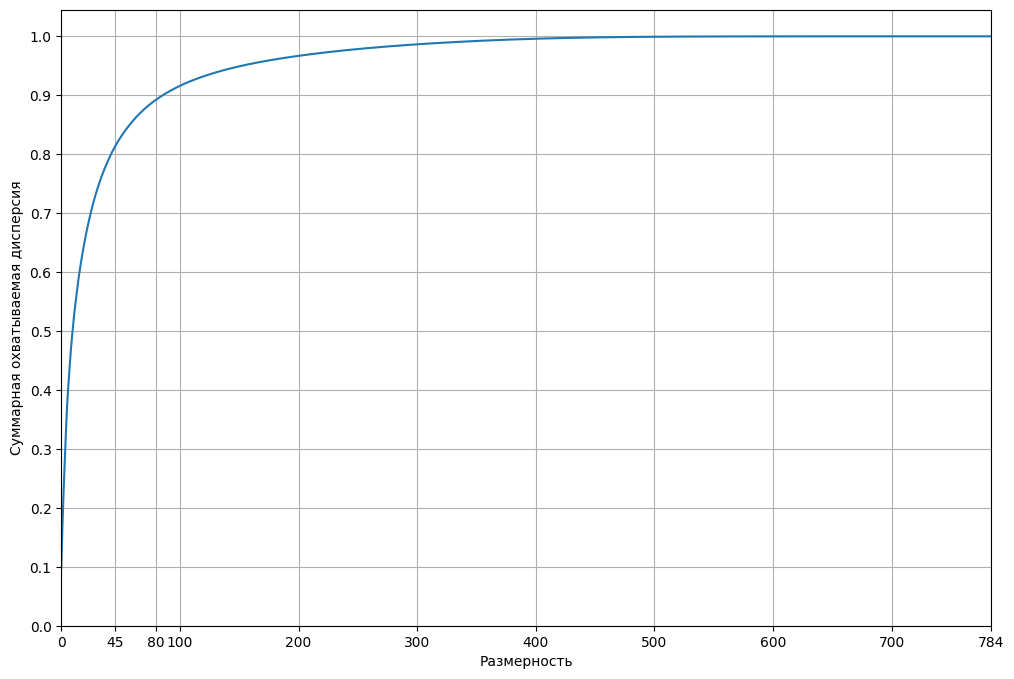

In [8]:
plt.figure(figsize=(12, 8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Размерность")
plt.ylabel("Суммарная охватываемая дисперсия")
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xticks(list(plt.xticks()[0]) + [45, 80, 28 * 28])
plt.xlim(0, 28 * 28)
plt.grid(True)

Итак, всего 400 наиболее информативных пикселей описывают около 100% дисперсии, 80 пикселей около 90% и 45 пикселей около 82%.


Как и предполагалось, размерность датасета можно снизить, при это не сильно ухудшив результаты кластеризации.

## Собственная реализация K-means

In [9]:
import numpy.typing as npt
from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.utils import check_array, check_scalar, check_random_state
from sklearn.utils.validation import check_is_fitted
from sklearn.utils.estimator_checks import check_estimator


class SimpleKMeans(BaseEstimator, ClusterMixin):

    def __init__(self, n_clusters=8, *, tol=1e-4, random_state=None):
        self.n_clusters = n_clusters
        self.tol = tol
        self.random_state = random_state

    def fit(self, X: npt.ArrayLike, y=None):
        self.n_clusters = check_scalar(self.n_clusters, "n_clusters", int, min_val=1)
        self.tol = check_scalar(self.tol, "tol", float, min_val=0)
        self.random_state_ = check_random_state(self.random_state)
        X = check_array(X)
        self.n_features_in_ = X.shape[1]
        self.cluster_centers_ = X[self.random_state_.choice(len(X), size=self.n_clusters, replace=False), :]
        max_center_shift = np.inf
        while max_center_shift > self.tol:
            self.labels_ = self._get_labels(X)
            new_centers = np.empty((self.n_clusters, self.n_features_in_))
            for label in np.unique(self.labels_):
                new_centers[label] = np.mean(X[self.labels_ == label], axis=0)
            max_center_shift = np.max(np.linalg.norm(self.cluster_centers_ - new_centers, axis=1))
            self.cluster_centers_ = new_centers
        return self
    
    def _get_labels(self, X: npt.NDArray) -> npt.NDArray:
        dists_to_centers = np.linalg.norm(
            X[..., None] - self.cluster_centers_.T, axis=1
        )
        labels = np.argmin(dists_to_centers, axis=1)
        return labels

    def predict(self, X: npt.ArrayLike) -> npt.NDArray:
        check_is_fitted(self)
        X = check_array(X)
        return self._get_labels(X)

check_estimator(SimpleKMeans())

## Обучение

Так как для каждой картинки известно, что на ней изображено, то будем использовать метрики ориентирующиеся на это. В рамках этой задачи будем пользоваться:
* Adjusted Rand Index (ARI)
* Adjusted Mutual Information (AMI)
* Fowlkes-Mallows Index (FMI)

In [10]:
Xs = [X.to_numpy(dtype=np.float64)]
for reduced_dims in [400, 80, 45]:
    pca = PCA(n_components=reduced_dims)
    X_reduced = pca.fit_transform(X)
    Xs.append(X_reduced)

Подбор гипер-параметров для каждой метрики будем осуществлять отдельно, т.е получим три набора, каждый из которых даёт лучшие результаты по какой-либо метрике.

In [20]:
import pathlib
import itertools
import time
from sklearn.base import clone
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, fowlkes_mallows_score

RESULTS_PATH = pathlib.Path("cv_results.csv")


def train_and_store(estimator, param_grid: dict | None = None):
    param_grid = param_grid if param_grid is not None else {}
    param_combs = [
        dict(params) for params in
        itertools.product(
            *([(name, v) for v in vs] for (name, vs) in param_grid.items())
        )
    ]

    results = []
    for X in Xs:
        best_ari = None
        best_ami = None
        best_fmi = None
        for params in param_combs:
            cloned_estimator = clone(estimator).set_params(**params)
            start_t = time.perf_counter()
            pred = cloned_estimator.fit_predict(X)
            fit_predict_time_s = (time.perf_counter() - start_t)
            ari = adjusted_rand_score(y, pred)
            if best_ari is None or ari > best_ari[0]:
                best_ari = ari, fit_predict_time_s, params
            ami = adjusted_mutual_info_score(y, pred)
            if best_ami is None or ami > best_ami[0]:
                best_ami = ami, fit_predict_time_s, params
            fmi = fowlkes_mallows_score(y, pred)
            if best_fmi is None or fmi > best_fmi[0]:
                best_fmi = fmi, fit_predict_time_s, params
        res = { "Clusterer": estimator.__class__.__name__,
                "Input dimension": X.shape[1],
                "Mean time, s": np.mean([best_ari[1], best_ami[1], best_fmi[1]]),
                "ARI": best_ari[0],
                "AMI": best_ami[0],
                "FMI": best_fmi[0]
              }
        results.append(res)
        print(res)

    pd.DataFrame(results).to_csv(RESULTS_PATH, mode="a", header=not RESULTS_PATH.exists())

In [21]:
%%time

train_and_store(SimpleKMeans(n_clusters=10, random_state=0))

{'Clusterer': 'SimpleKMeans', 'Input dimension': 784, 'Mean time, s': 45.078607599999486, 'ARI': 0.3653652630213717, 'AMI': 0.49635607263330805, 'FMI': 0.43143741735783886}
{'Clusterer': 'SimpleKMeans', 'Input dimension': 400, 'Mean time, s': 33.19977219999964, 'ARI': 0.36567258176829054, 'AMI': 0.4967415844872129, 'FMI': 0.43172069382063377}
{'Clusterer': 'SimpleKMeans', 'Input dimension': 80, 'Mean time, s': 5.898569099999804, 'ARI': 0.36609252072611437, 'AMI': 0.4966543977850631, 'FMI': 0.432112753352197}
{'Clusterer': 'SimpleKMeans', 'Input dimension': 45, 'Mean time, s': 3.4593410999996195, 'ARI': 0.3630941224304738, 'AMI': 0.4979422303039548, 'FMI': 0.4294428954340891}
CPU times: total: 1min 27s
Wall time: 1min 27s


In [27]:
%%time
from sklearn.cluster import KMeans

train_and_store(
    KMeans(n_clusters=10, n_init="auto", random_state=0),
    param_grid={"algorithm": ["lloyd", "elkan"]}
)

{'Clusterer': 'KMeans', 'Input dimension': 784, 'Mean time, s': 0.6663762000007409, 'ARI': 0.36161008248551607, 'AMI': 0.49159702950859585, 'FMI': 0.42923205269026965}
{'Clusterer': 'KMeans', 'Input dimension': 400, 'Mean time, s': 0.3927683000001707, 'ARI': 0.3612036958995223, 'AMI': 0.49136488670431183, 'FMI': 0.4288679814498445}
{'Clusterer': 'KMeans', 'Input dimension': 80, 'Mean time, s': 0.0892057000000932, 'ARI': 0.3201927877936523, 'AMI': 0.45191239761923496, 'FMI': 0.3908998085173489}
{'Clusterer': 'KMeans', 'Input dimension': 45, 'Mean time, s': 0.06543929999952525, 'ARI': 0.3904967999353647, 'AMI': 0.4999743464935378, 'FMI': 0.45449377250455425}
CPU times: total: 40.8 s
Wall time: 3.08 s


In [28]:
%%time
from sklearn.cluster import DBSCAN

train_and_store(
    DBSCAN(n_jobs=-1),
    param_grid={"eps": [750, 1000, 1500], "min_samples": [20, 100, 150]}
)

{'Clusterer': 'DBSCAN', 'Input dimension': 784, 'Mean time, s': 3.4395835333331584, 'ARI': 0.0924814166100469, 'AMI': 0.2371171858344371, 'FMI': 0.34761722694211356}
{'Clusterer': 'DBSCAN', 'Input dimension': 400, 'Mean time, s': 1.8739132999996098, 'ARI': 0.09160238982147899, 'AMI': 0.2372732754259328, 'FMI': 0.3476840891527879}
{'Clusterer': 'DBSCAN', 'Input dimension': 80, 'Mean time, s': 0.49897583333283063, 'ARI': 0.10221762100266117, 'AMI': 0.28006503922979065, 'FMI': 0.345852773504378}
{'Clusterer': 'DBSCAN', 'Input dimension': 45, 'Mean time, s': 0.36169960000036855, 'ARI': 0.09834837998618813, 'AMI': 0.2470331064640788, 'FMI': 0.34818435140620757}
CPU times: total: 21min 34s
Wall time: 59.4 s


# Результаты

In [38]:
results = pd.read_csv(RESULTS_PATH)

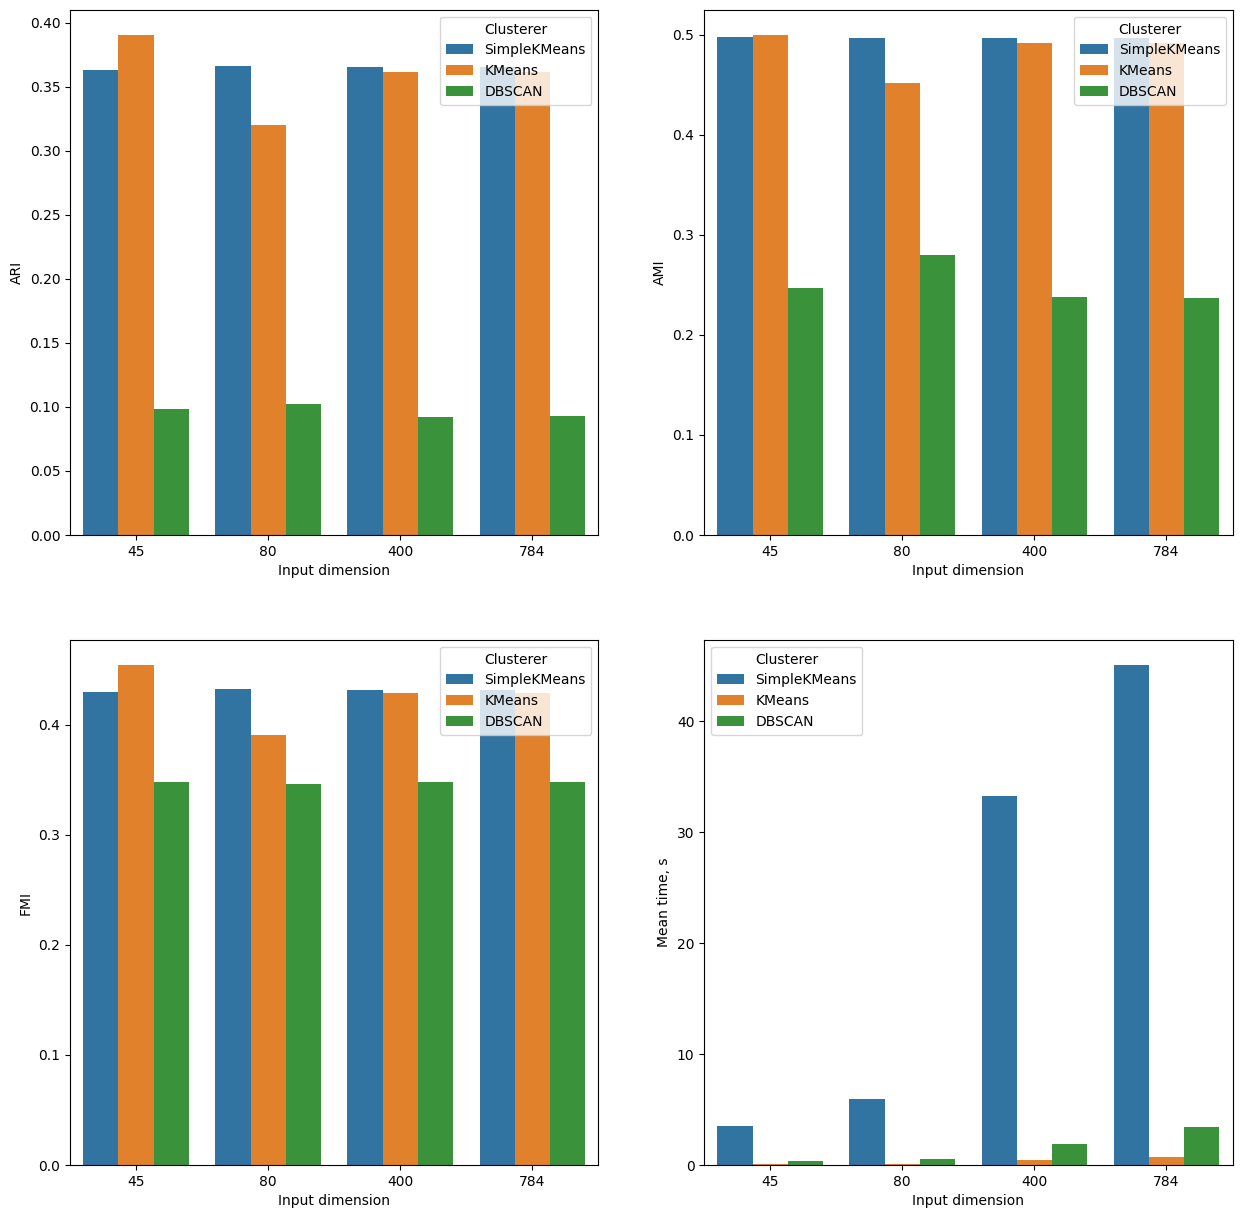

In [41]:
import seaborn as sns

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(15, 15))

for m_name, ax in zip(["ARI", "AMI", "FMI", "Mean time, s"], axs.flatten()):
    sns.barplot(results, x="Input dimension", y=m_name, hue="Clusterer", ax=ax)

Сделаем выводы:

* Уменьшение размерности при помощи PCA не ухудшило результаты, но при этом снизило время для обучения.

* По скорости обучения реализация KMeans из scikit-learn обходит DBSCAN

* По всем качественным метрикам KMeans обходит DBSCAN. Но несмотря на это, результаты сложно назвать "хорошими"